In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from icecream import ic
import os

In [2]:
class IsingLattice:

    def __init__(self, lattice_size, j1, j2):
        self.lattice_size = lattice_size
        self.num_sites = lattice_size*lattice_size
        self.j1 = j1
        self.j2 = j2

        lattice_state = np.random.randint(2, size=(lattice_size,lattice_size))
        self.lattice_state = np.where(lattice_state==0,-1,1)

    def plot_state(self):
        plt.imshow(self.lattice_state)
        plt.axis("off")

    def flip_spin(self,i,j):
        self.lattice_state[i,j]*= -1

    def print_info(self):
        print("Lattice Size = ",self.lattice_size)
        print("j1 = ",self.j1)
        print("j2 = ",self.j2)
        print("Total number of spins = ",self.num_sites)

    def spin_energy(self,i,j):
        # Define nearest neighbour interaction
        l=self.lattice_size
        spin_ij = self.lattice_state[i,j]
        nearest_up = self.lattice_state[(i-1)%l,j]
        nearest_down = self.lattice_state[(i+1)%l,j]
        nearest_left = self.lattice_state[i,(j-1)%l]
        nearest_right = self.lattice_state[i,(j+1)%l]

        sum_nearest_neighbour = nearest_down + nearest_left + nearest_right + nearest_up

        # Define second nearest neighbour interaction
        right_up = self.lattice_state[(i-1)%l,(j+1)%l]
        right_down = self.lattice_state[(i+1)%l,(j-1)%l]
        left_up = self.lattice_state[(i-1)%l,(j-1)%l]
        left_down = self.lattice_state[(i+1)%l,(j+1)%l]

        sum_second_nearest_neighbour = right_down + right_up + left_down + left_up
        # Define total Ising energy of spin E = j1 * sum(no of nearest neighbour) + j2 * sum(no of second nearest neigbour)
        if self.j2 == 0:
            spin_energy = (-self.j1 * sum_nearest_neighbour * spin_ij)
        else:
            spin_energy = (-self.j1 * sum_nearest_neighbour * spin_ij) + (-self.j2 * sum_second_nearest_neighbour * spin_ij)

        return spin_energy
    
    def total_energy(self):
        #total energy of all spins, but we divide it to no of spins at the end to normalize the energy, we also divide by 2 two to prevent repetition
        total_energy = 0
        for i in range(self.lattice_size):
            for j in range(self.lattice_size):
                total_energy += self.spin_energy(i,j)
        
        return total_energy/2.0/self.num_sites
    
    def spin_mag(self):
    #Magnetization is 1/number of spins * total of spins (include nominal value of state (-1,1))
        return self.lattice_state.sum() / self.num_sites


In [3]:
test_lattice = IsingLattice(30,1,0)
test_lattice.num_sites
test_lattice.print_info()

Lattice Size =  30
j1 =  1
j2 =  0
Total number of spins =  900


0


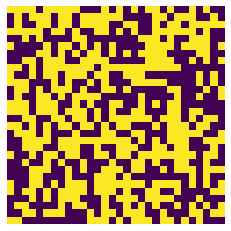

In [4]:
print(test_lattice.spin_energy(1,1))
test_lattice.plot_state()

In [5]:
test_lattice.spin_energy(0,1)

-4

In [6]:
test_lattice.total_energy()

-0.017777777777777778

In [7]:
print("Energy is",test_lattice.total_energy())
print("Magnetization is",test_lattice.spin_mag())

Energy is -0.017777777777777778
Magnetization is 0.05555555555555555


In [8]:
#Metropolis Algorithm 
def sweep_lattice(lattice:IsingLattice,T):
    '''
    Scan the lattice once ly, flip the spin if Metropolis criterion holds: if energy<=0 or generated random number<np.exp(-energy_change/temperature)
    '''

    flip_count = 0
    no_flip_count = 0

    for x in range(lattice.num_sites):
        i, j = np.random.randint(lattice.lattice_size, size=2)
        energy_initial = lattice.spin_energy(i,j)
        lattice.flip_spin(i,j)
        energy_flipped = lattice.spin_energy(i,j)
        exchange_energy = energy_flipped - energy_initial
        lattice.flip_spin(i,j)
        if exchange_energy <= 0 or \
            np.random.random()<=np.exp(-exchange_energy/T):
            lattice.flip_spin(i,j)


In [9]:
def thermalize(lattice:IsingLattice,sweep_num,T_hot,T_cold):
    #thermalize dedigimiz iki T arasini yuksek sayida parcaya bolup rate of T change i azaltmak
    for T in np.linspace(T_hot, T_cold, sweep_num):
        sweep_lattice(lattice, T)

In [11]:
def sweep_lattice_n_times(lattice, T, num_sweep):
    for _ in range(num_sweep):
        sweep_lattice(lattice=lattice, T=T)

In [10]:
def save_img(lattice_state, save_file_name):
    plt.imshow(lattice_state)
    plt.axis('off')
    plt.savefig(save_file_name)
    plt.close()

In [15]:
def mc_simulation(lattice:IsingLattice, T:np.array, num_sweeps, num_sample):
    # Get data for T[0]
    # energy needs to be dimension -> (T.size, num_sample)
    # First row of this would be energy values at T[0]
    energy = np.zeros((T.size, num_sample))
    magnetization = np.zeros((T.size, num_sample))

    file_name = f'L_{lattice.lattice_size}_J1_{lattice.j1:.1f}_J2_{lattice.j2:.3f}'
    os.makedirs(file_name, exist_ok=True)

    thermalize(lattice, 1000, 100, T[0])

    for n in range(num_sample):
        sweep_lattice_n_times(lattice, T[0], num_sweep=num_sweeps)
        save_img(lattice_state=lattice.lattice_state, save_file_name=file_name + "/" + file_name + f'_T_{T[0]:.3f}_n_{n}.png')
        energy[0,n] = lattice.total_energy()
        magnetization[0,n] = lattice.spin_mag()

    for i in tqdm(range(T.size-1)):
        thermalize(lattice,1000, T[i], T[i+1])
        # Now we want to collect data
        for n in range(num_sample):
            sweep_lattice_n_times(lattice, T[i+1], num_sweep=num_sweeps)
            save_img(lattice_state=lattice.lattice_state, save_file_name=file_name + "/" + file_name + f'_T_{T[i+1]:.3f}_n_{n}.png')
            energy[i+1,n] = lattice.total_energy()
            magnetization[i+1,n] = lattice.spin_mag()
            
    print('Simulation done.')

    print('Saving data...')
    np.savetxt(file_name + "/" +file_name + '_energy.csv', energy, delimiter=',')
    np.savetxt(file_name + "/" +file_name + '_magnetization.csv', magnetization, delimiter=',')
    return energy, magnetization

In [17]:
test_lattice_2 = IsingLattice(10, 1, 0)
T = np.arange(4,0.95,-0.05)

In [18]:
ene, mag = mc_simulation(lattice=test_lattice_2, T=T,num_sweeps=500, num_sample=10)

  5%|▌         | 3/60 [01:20<25:31, 26.86s/it]


KeyboardInterrupt: 

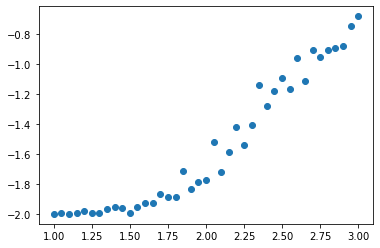

In [ ]:
plt.scatter(T,ene)

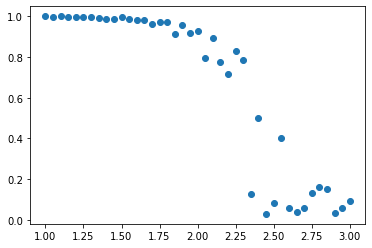

In [ ]:
plt.scatter(T,np.abs(mag))